### Human In the Loop
Review
For human-in-the-loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals
Now, let's talk about the motivations for human-in-the-loop:

(1) Approval - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) Debugging - We can rewind the graph to reproduce or avoid issues

(3) Editing - You can modify the state

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows.


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="qwen/qwen3-32b")

In [2]:
## Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.
    
    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b
    
    Args:
        a: first int
        b: second int
    """
    return a + b 

def divide(a: int, b: int) -> float:
    """Divide a and b
    
    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [3]:
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F0958F84D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F095A340B0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b', 'parameters': {'properties': {'a': {'description': 'first int', '

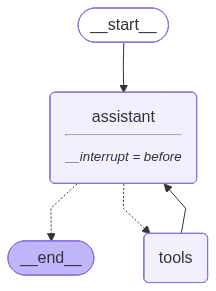

In [5]:
from IPython.display import Image,display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

sys_msg = SystemMessage(content="You are a helpfull assistant tasked with performing arithmetic on a ")

## node definition
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

#Graph
builder=StateGraph(MessagesState)

## Define nodes:
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

#Define the Edges
builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","assistant")

memory= MemorySaver()

graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

#show
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}



In [7]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [8]:
state= graph.get_state(thread)
state.next

('assistant',)

In [9]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x000001F095C2E140>

In [11]:
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (npygv48j8)
 Call ID: npygv48j8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
